In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf

import warnings 
warnings.filterwarnings('ignore')
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

E:\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
E:\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
E:\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
E:\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is 

Num GPUs Available:  1


E:\anaconda3\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
E:\anaconda3\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
E:\anaconda3\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
E:\anaconda3\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:544: FutureWarning: Passing (type, 1) or '1ty

# Second Way to Prediction Data

# Read Data

In [2]:
train_data = pd.read_csv('dataset/train_data.csv', sep=';').dropna()
test_data = pd.read_csv('dataset/test_data.csv', sep=';').dropna()

train_data.columns = ['1','Time', 'Bytes', 'Packages']
test_data.columns = ['1','Time', 'Bytes', 'Packages']
print('train_shape: ',train_data.shape)
print('test_shape: ',test_data.shape)

train_shape:  (242391, 4)
test_shape:  (103907, 4)


In [3]:
# Отрбрасываем выбросы данных 
def clearData(dataset):
    ind_missing = train_data[train_data['Bytes'] > 1039828].index
    while len(ind_missing) != 0:
        for index in ind_missing:
            mean = (train_data["Bytes"][index - 1] + train_data["Bytes"][index + 1]) / 2
            train_data["Bytes"][index] = mean
        ind_missing = train_data[train_data['Bytes'] > 1039828].index
        
    ind_missing = train_data[train_data['Packages'] > 2000].index
    while len(ind_missing) != 0:
        for index in ind_missing:
            mean = (train_data["Packages"][index - 1] + train_data["Packages"][index + 1]) / 2
            train_data["Packages"][index] = mean
        ind_missing = train_data[train_data['Packages'] > 2000].index
    return dataset

In [4]:
timeDelta = 3600
LAST_COUNT = 6

# Clean data from emissions

In [5]:
train_data = clearData(train_data)
test_data = clearData(test_data)

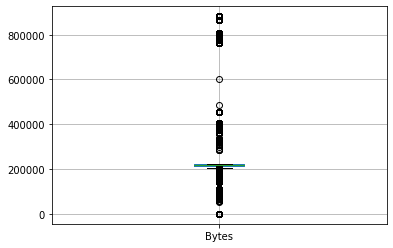

In [6]:
# Проверка разброса данных байтов
train_data.boxplot(column=['Bytes'])

In [7]:
train_data["Bytes"].max()

882298.0

# Parametrs

In [8]:
def findIndexWhereNextTime(startIndex, data, timeDelta):
#     print(startIndex)
    startIndex += 1
    startTime = data[startIndex][1]
    # Чтобы примерно попадать в интервал
    offset = 50
    for index in range(startIndex, len(data)):
        time = data[index][1]
        
        if (startTime + timeDelta) == time:
#             print("Delta Time == time")
            return index
        
        if time > (startTime + timeDelta - offset) and (time < (startTime + timeDelta + offset)):
#             print("Time in interval between two indexes")
            return index
        
        if timeDelta < (time - data[index - 1][1]):
#             print("Time delta Less than Interval")
            return index
    
    return None
        
def generateDatasetWithSumElements(dataset):
    dataset = dataset.values
    newDataset = []
    
    # current index 
    currentIndex = 0
    time = dataset[currentIndex][1]
    findNextIndex = findIndexWhereNextTime(currentIndex, dataset, timeDelta)
    
    while findNextIndex != None:
        newBytes = dataset[currentIndex: findNextIndex][:,2].sum()
        newPackages = dataset[currentIndex: findNextIndex][:,3].sum()
        newDataset.append([time, newBytes, newPackages])
        
        currentIndex = findNextIndex
        time = dataset[currentIndex][1]
        findNextIndex = findIndexWhereNextTime(currentIndex, dataset, timeDelta)
#         print("Current Index ", currentIndex, " Next ", findNextIndex)
    return newDataset


In [9]:
train_dataset = np.array(generateDatasetWithSumElements(train_data))
# избавляемся от первого непонятного всплеска
# train_dataset = np.delete(train_dataset,0,0)

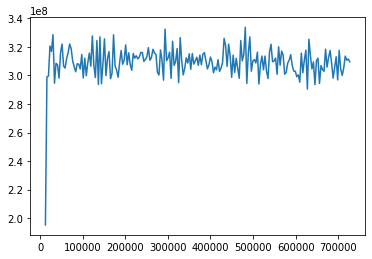

In [10]:
f, ax = plt.subplots(1)
xdata = train_dataset[:,0]
ydata = train_dataset[:,1]
ax.plot(xdata, ydata)
# ax.set_ylim(train_dataset[:,1][1])
plt.show(f)

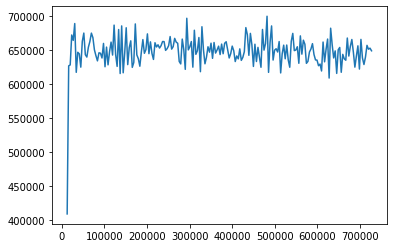

In [11]:
f, ax = plt.subplots(1)
xdata = train_dataset[:,0]
ydata = train_dataset[:,2]
ax.plot(xdata, ydata)
# ax.set_ylim(train_dataset[:,2][1])
plt.show(f)

In [12]:
train_dataset[:,2][2]
# train_dataset = np.delete(train_dataset,1,1)train_dataset[:,0][0]

627632.0

In [13]:
train_dataset = np.delete(train_dataset,0,1)
n = len(train_dataset)
train_data = pd.DataFrame(train_dataset[0:int(n*0.7)], columns=[ 'Bytes', 'Packages'])
val_data = pd.DataFrame(train_dataset[int(n*0.7):], columns=['Bytes', 'Packages'])
# train_data = pd.DataFrame(train_dataset[0:int(n*0.7)], columns=[ 'Bytes'])
# val_data = pd.DataFrame(train_dataset[int(n*0.7):], columns=['Bytes'])

In [14]:
train_data.describe()

,Bytes,Packages
count,1.410000e+02,141.000000
mean,3.099016e+08,649034.869515
std,1.289023e+07,26985.472972
min,1.952545e+08,408810.500000
25%,3.050894e+08,638715.000000
50%,3.103292e+08,649844.000000
75%,3.157723e+08,661210.500000
max,3.338154e+08,699196.000000


# Normalized data

In [ ]:
from sklearn.preprocessing import MaxAbsScaler

# create an abs_scaler object
abs_scaler = MaxAbsScaler()

# calculate the maximum absolute value for scaling the data using the fit method
abs_scaler.fit(train_data)

# the maximum absolute values calculated by the fit method
abs_scaler.max_abs_
# array([4.0e+05, 1.7e+01])

# transform the data using the parameters calculated by the fit method (the maximum absolute values)
train_scaled_data = abs_scaler.transform(train_data)

# store the results in a data frame
normalizedTrain = pd.DataFrame(train_scaled_data, columns=train_data.columns)

val_scaled_data = abs_scaler.transform(val_data)
normalizedVal = pd.DataFrame(val_scaled_data, columns=val_data.columns)

# visualize the data frame
print("train shape =", normalizedTrain.shape)
print("val shape =", normalizedVal.shape)

# Generate Dataset

In [ ]:
def generateDataset(dataset):
    x_train = []
    y_train = []
    
    size = len(dataset) - LAST_COUNT - 1
    for index in range(0, size):
        x_train.append(list(dataset[index: index + LAST_COUNT]))
        y_train.append(dataset[index + LAST_COUNT])
    return (np.array(x_train), np.array(y_train))

In [ ]:
X_train, y_train = generateDataset(normalizedTrain.values)
X_val, y_val = generateDataset(normalizedVal.values)

# Train Model

In [ ]:
def compile_and_fit(model, trainX, trainY, validData, patience=100, MAX_EPOCHS = 100):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='auto')

    model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.1),
                metrics=[tf.keras.metrics.MeanAbsolutePercentageError(),tf.keras.metrics.RootMeanSquaredError()])

    history = model.fit(trainX, trainY,batch_size=24, epochs=MAX_EPOCHS,
                      validation_data=validData,
                      callbacks=[early_stopping])
    return history

In [ ]:


multi_step_dense = tf.keras.Sequential([
    # Shape: (time, features) => (time*features)
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=256, activation='relu'),
    tf.keras.layers.Dense(units=2)
    # Add back the time dimension.
    # Shape: (outputs) => (1, outputs)
#     tf.keras.layers.Reshape([1, -1]),
])


history = compile_and_fit(multi_step_dense, X_train, y_train, (X_val, y_val), MAX_EPOCHS= 100000)

# test on trained data

In [ ]:
predicted = multi_step_dense.predict(X_val)

f, ax = plt.subplots(1)
# xdata = y_test.values[:,0]
ax.plot(y_val[:,0])
ax.plot(predicted[:,0])
# ax.set_ylim(train_dataset[:,2][1])
plt.show(f)

In [ ]:
predicted = multi_step_dense.predict(X_train)

f, ax = plt.subplots(1)
# xdata = y_test.values[:,0]
ax.plot(y_train[:,0])
ax.plot(predicted[:,0])
# ax.set_ylim(train_dataset[:,2][1])
plt.show(f)

In [ ]:
predicted = multi_step_dense.predict(X_test)
multi_step_dense.evaluate(X_test, y_test)

# Predict Test Dataset


In [ ]:
predicted = multi_step_dense.predict(X_test)
multi_step_dense.evaluate(X_test, y_test)

In [ ]:
predicted = pd.DataFrame(predicted, columns=[ 'Bytes', 'Packages'])
y_test = pd.DataFrame(y_test, columns=[ 'Bytes', 'Packages'])

# y_test_un = unNormalizedData(y_test,trainMean, trainSTD)
# predicted_un = unNormalizedData(predicted, trainMean, trainSTD)
# predicted_un

In [ ]:
plt.plot(y_test.values[:,0])

In [ ]:
plt.plot((predicted).values[:,0])

In [ ]:
f, ax = plt.subplots(1)
xdata = y_test.values[:,0]
ax.plot(xdata)
ax.plot(predicted.values[:,0])
# ax.set_ylim(train_dataset[:,2][1])
plt.show(f)

In [ ]:
def percentage_error(actual, predicted):
    res = np.empty(actual.shape)
    for j in range(actual.shape[0]):
        if actual[j] != 0:
            res[j] = (actual[j] - predicted[j]) / actual[j]
        else:
            res[j] = predicted[j] / np.mean(actual)
    return res

def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs(percentage_error(np.asarray(y_true), np.asarray(y_pred)))) * 100

# predicted_un = predicted_un * -1
print("MAPE BYTES = ", mean_absolute_percentage_error(y_test.values[:,0], predicted.values[:,0]))
print("MAPE PACKAGES = ", mean_absolute_percentage_error(y_test.values[:,1], predicted.values[:,1]))

In [ ]:
inversed_predicted = abs_scaler.inverse_transform(predicted)
inverse_y_test = abs_scaler.inverse_transform(y_test)

print("Inversed MAPE BYTES = ", mean_absolute_percentage_error(inverse_y_test[:,0], inversed_predicted[:,0]))
print("Inversed MAPE PACKAGES = ", mean_absolute_percentage_error(inverse_y_test[:,1], inversed_predicted[:,1]))

In [ ]:
f, ax = plt.subplots(1)
ax.plot(inverse_y_test[:,0])
ax.plot(inversed_predicted[:,0])
# ax.set_ylim(train_dataset[:,2][1])
plt.show(f)

# Save Model

In [ ]:
multi_step_dense.save("ouput.h5")